# PCA

Select a set of grayscale images (e.g., faces, landscapes, or any other category).
Normalize the images by scaling pixel values to a range [0, 1].

## PCA Implementation:
Write a Python function to perform PCA on the images.
Implement the following steps:
1. Convert the image into a 2D matrix where each row represents an image and each column
represents a pixel value.
2. Compute the covariance matrix of the image data.

3. Calculate the eigenvalues and eigenvectors of the covariance matrix.

4. Sort the eigenvectors based on the eigenvalues in descending order.

5. Select the top k eigenvectors to form the principal components.

6. Project the original images onto the lower-dimensional subspace defined by the selected
principal components.
## Reconstruction of Images:
1. Using the selected principal components, reconstruct the images.
2. Compare the reconstructed images with the original images to observe the effects of
dimensionality reduction.
## Experimentation:
1. Vary the number of principal components (k) and observe the impact on the quality of the
reconstructed images.
2. Plot the variance explained by the principal components and determine the optimal number
of components that balances compression and quality.
## Visual Analysis:
1. Display the original images alongside the reconstructed images for different values of k.

2. Comment on the visual quality of the images and how much information is lost during
compression.
## Error Analysis:
1. Compute the Mean Squared Error (MSE) between the original and reconstructed images.
2. Analyze the trade-off between compression and reconstruction error.

In [15]:
import cv2
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from pandas.core.interchange.from_dataframe import primitive_column_to_ndarray
from sklearn.decomposition import PCA

In [16]:
import zipfile
import numpy as np
import cv2

faces = {}
target_size = (64, 64)  # Einheitliche Größe für PCA

with zipfile.ZipFile("../data/assignment_2/images.zip") as facezip:
    for filename in facezip.namelist():
        if filename.endswith("/") or not filename.lower().endswith((".jpg", ".jpeg", ".png", ".pgm")):
            continue

        with facezip.open(filename) as image_file:
            img = cv2.imdecode(np.frombuffer(image_file.read(), np.uint8), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                # Hier wird vereinheitlicht:
                img = cv2.resize(img, target_size)
                faces[filename] = img

print(f"✅ {len(faces)} Bilder geladen, alle auf {target_size} skaliert.")


✅ 152 Bilder geladen, alle auf (64, 64) skaliert.


In [ ]:
print(len(faces))

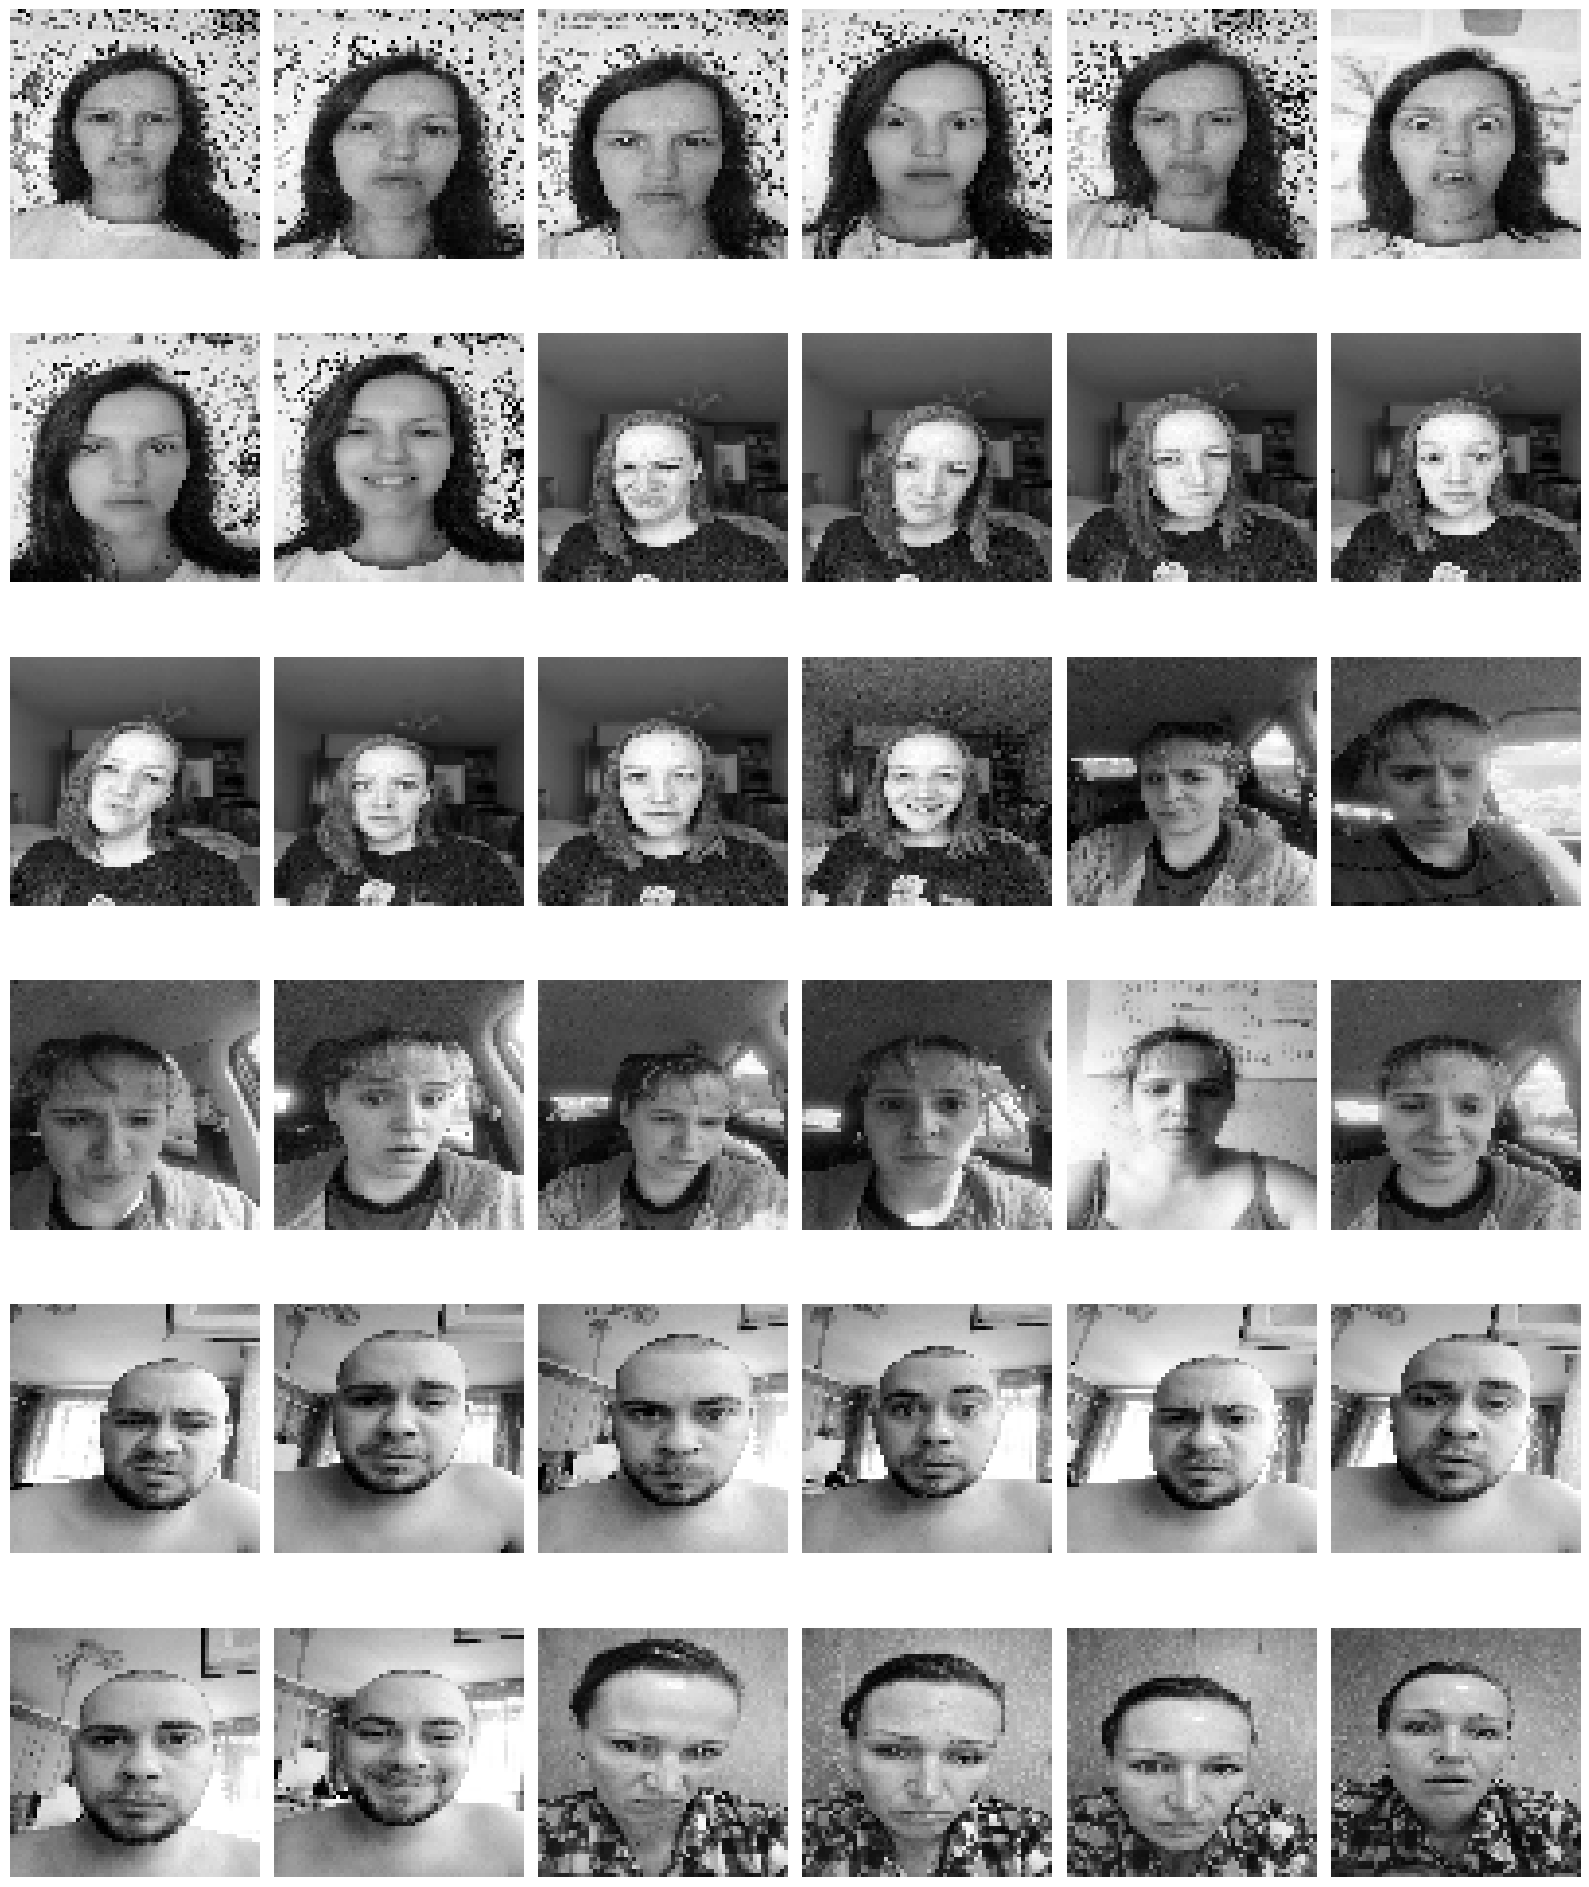

In [36]:
fig, axes = plt.subplots(6,6,sharex=True,sharey=True,figsize=(16,20))
faceimages = list(faces.values())[:36]

for i in range(36):
    axes[i//6, i%6].imshow(faceimages[i], cmap="gray")
    axes[i//6, i%6].axis("off")

plt.tight_layout()
plt.show()


PCA done: k=40, variance = 88.80%
Original dtype: uint8
Original min: 1 max: 254


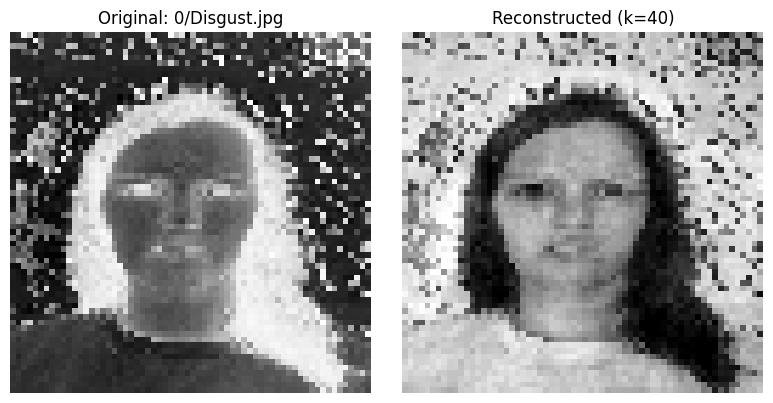

In [39]:
import numpy as np

def perform_pca_from_faces(faces, k, normalize=True):
    # 1. convert pics into matrix
    fc = faces.copy()
    X = np.array([img.flatten() for img in fc.values()], dtype=np.float64)
    if normalize:
        X /= 255.0
    #print(f"Matric: {X.shape}")

    # 2. covariance matrix
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean

    cov = np.cov(X_centered, rowvar=False)

    # 3. Eigenvalues & Eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov)

    # 4. sort eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # 5. select top k eigenvectors
    W = eigvecs[:, :k]


    # 6. project original images onto lower-dimensional subspace
    X_proj = X_centered @ W

    # infos covariance
    explained_var_ratio = eigvals / np.sum(eigvals)
    explained_var_ratio_cum = np.cumsum(explained_var_ratio)

    print(f"PCA done: k={k}, variance = {explained_var_ratio_cum[k-1]*100:.2f}%")

    return {
        "X": X,
        "X_proj": X_proj,
        "mean": X_mean,
        "components": W,
        "eigvals": eigvals,
        "explained_var_ratio": explained_var_ratio,
        "explained_var_ratio_cum": explained_var_ratio_cum,
    }


def reconstruct_from_pca(X_proj, components, mean):
    return X_proj @ components.T + mean



import matplotlib.pyplot as plt

# --- PCA ausführen ---
k = 40
result = perform_pca_from_faces(faces, k=k, normalize=True)

# --- Ein bestimmtes Bild auswählen (z. B. das erste im Dictionary) ---

img_name = list(faces.keys())[0]
original_img = list(faces.values())[:2][0]
img_index = list(faces.keys()).index(img_name)

# --- Rekonstruktion ---
reconstructed_flat = reconstruct_from_pca(result["X_proj"], result["components"], result["mean"])
reconstructed_img = reconstructed_flat[img_index].reshape(original_img.shape)


print("Original dtype:", original_img.dtype)
print("Original min:", original_img.min(), "max:", original_img.max())

# --- Vergleich plotten ---
orig_norm = original_img.astype(np.float32) / 255.0
recon_norm = reconstructed_img                     # ist schon [0,1]

plt.figure(figsize=(8,4), facecolor="white")
plt.subplot(1,2,1); plt.title(f"Original: {img_name}")
plt.imshow(1 - orig_norm, cmap="gray", vmin=0, vmax=1); plt.axis("off")

plt.subplot(1,2,2); plt.title(f"Reconstructed (k={k})")
plt.imshow(recon_norm, cmap="gray", vmin=0, vmax=1); plt.axis("off")
plt.tight_layout();
plt.show()



PCA done: k=10, variance = 73.48%
PCA done: k=25, variance = 83.86%
PCA done: k=50, variance = 91.04%
PCA done: k=100, variance = 97.50%
PCA done: k=150, variance = 100.00%
PCA done: k=200, variance = 100.00%


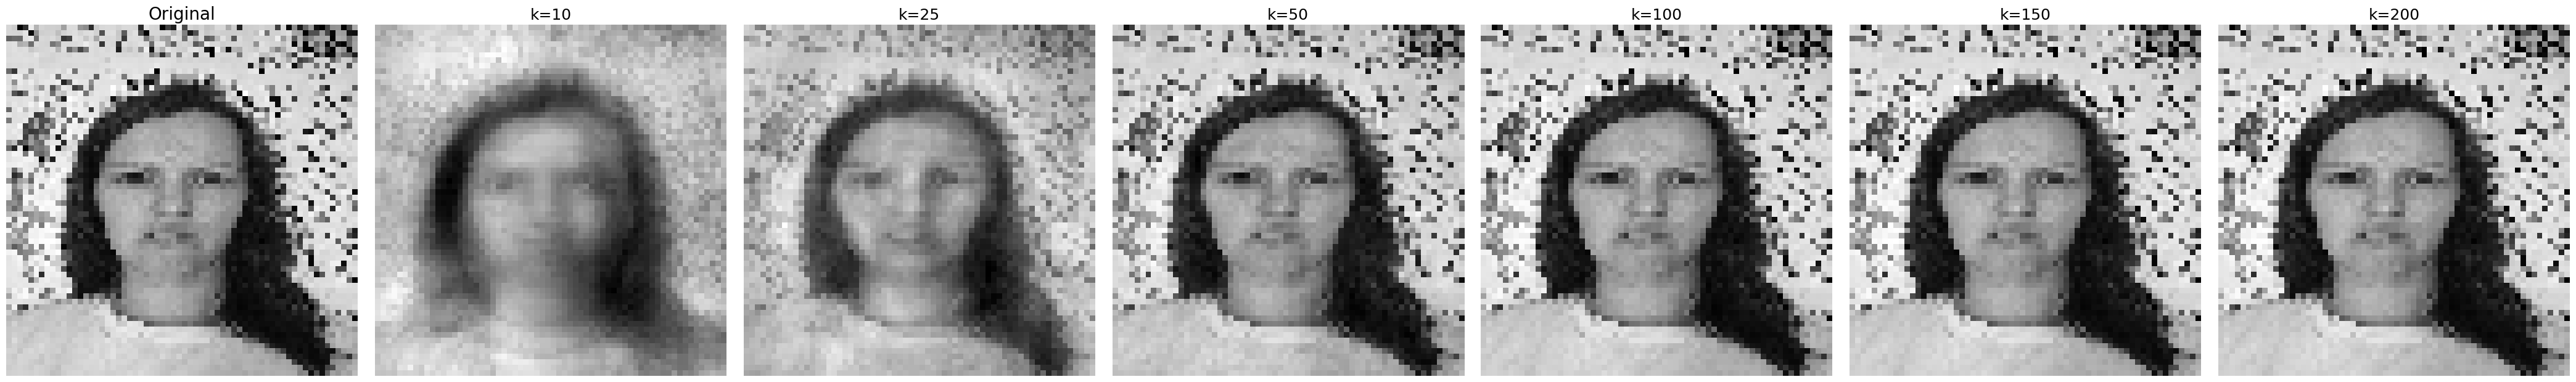

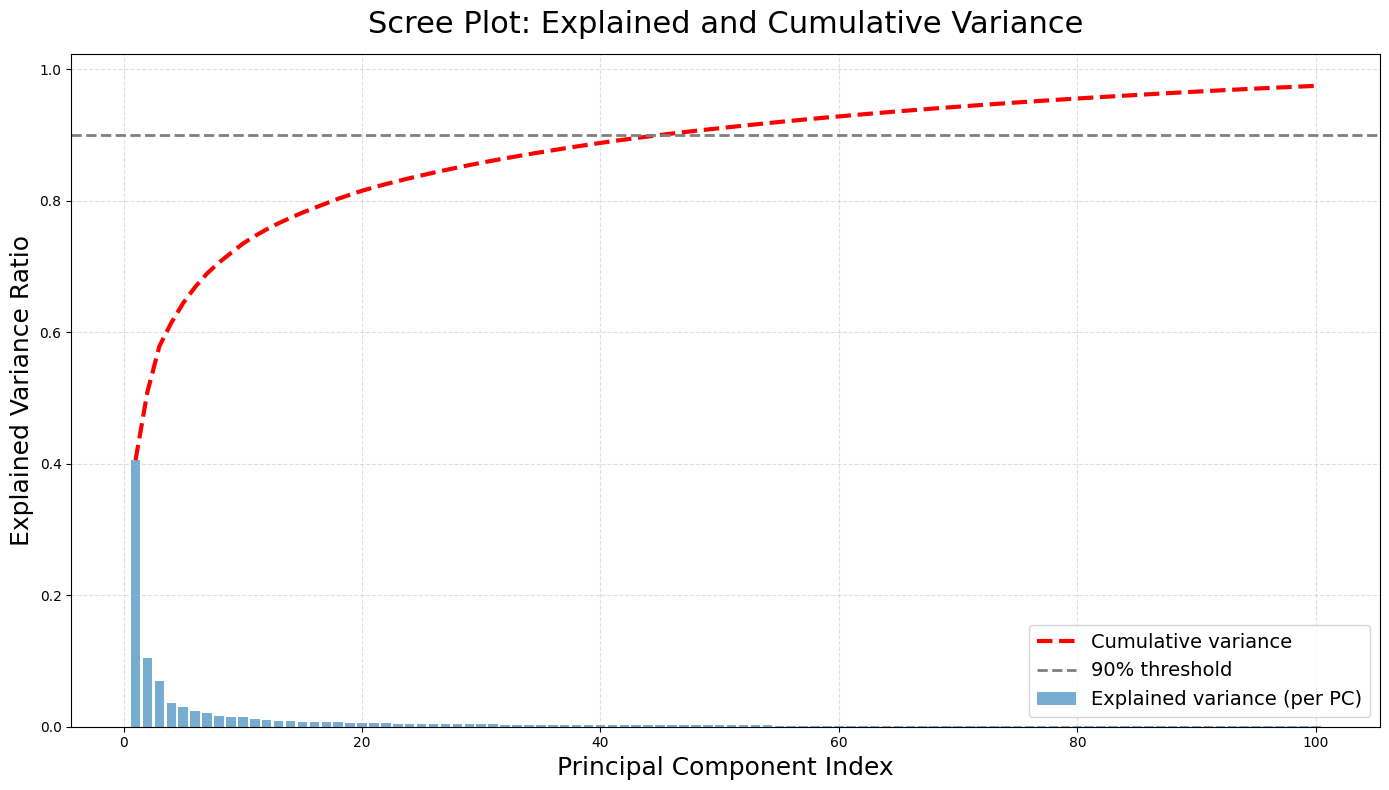

✅ Components for 90% variance: 45
✅ Components for 95% variance: 76


(45, 76)

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

def plot_pca_reconstructions(faces, k_values, image_indices, img_shape=(64, 64)):
    """
    Visualizes PCA reconstructions for multiple images and multiple k values.
    """
    face_list = list(faces.values())
    n_rows = len(image_indices)
    n_cols = len(k_values) + 1  # +1 for the original

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows))
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for row, i in enumerate(image_indices):
        # Original image
        axes[row, 0].imshow(face_list[i], cmap="gray")
        axes[row, 0].set_title("Original", fontsize=20)
        axes[row, 0].axis("off")

        # Reconstructions for different k
        for col, k in enumerate(k_values, start=1):
            out = perform_pca_from_faces(faces, k=k)
            X_recon = reconstruct_from_pca(out["X_proj"], out["components"], out["mean"])
            axes[row, col].imshow(X_recon[i].reshape(img_shape), cmap="gray")
            axes[row, col].set_title(f"k={k}", fontsize=18)
            axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


def plot_pca_variance(faces, max_k=200):
    """
    Plots Scree Plot and cumulative explained variance for PCA on face data.
    """
    X = np.array([img.flatten() for img in faces.values()])
    max_valid_k = min(max_k, X.shape[0], X.shape[1])

    pca = PCA(n_components=max_valid_k)
    pca.fit(X)

    explained_var = pca.explained_variance_ratio_
    cum_explained = np.cumsum(explained_var)

    plt.figure(figsize=(14, 8))
    plt.bar(range(1, max_valid_k + 1), explained_var, alpha=0.6, label="Explained variance (per PC)")
    plt.plot(range(1, max_valid_k + 1), cum_explained, "r--", linewidth=3, label="Cumulative variance")
    plt.axhline(0.9, color="gray", linestyle="--", linewidth=2, label="90% threshold")

    plt.xlabel("Principal Component Index", fontsize=18)
    plt.ylabel("Explained Variance Ratio", fontsize=18)
    plt.title("Scree Plot: Explained and Cumulative Variance", fontsize=22, pad=15)
    plt.legend(fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

    # Optional: print key thresholds
    k_90 = np.argmax(cum_explained >= 0.9) + 1
    k_95 = np.argmax(cum_explained >= 0.95) + 1
    print(f"✅ Components for 90% variance: {k_90}")
    print(f"✅ Components for 95% variance: {k_95}")
    return k_90, k_95


# --- Example usage ---
k_values = [10, 25, 50, 100, 150, 200]
image_indices = [0]  # or [0, 5, 10] for multiple faces

# 1️⃣ Plot reconstructions
plot_pca_reconstructions(faces, k_values, image_indices, img_shape=(64, 64))

# 2️⃣ Plot Scree Plot separately
plot_pca_variance(faces, max_k=100)


PCA done: k=10, variance = 73.48%
k=10   | Mean MSE=0.014831 | Explained Var=73.48%
PCA done: k=25, variance = 83.86%
k=25   | Mean MSE=0.009025 | Explained Var=83.86%
PCA done: k=50, variance = 91.04%
k=50   | Mean MSE=0.005011 | Explained Var=91.04%
PCA done: k=100, variance = 97.50%
k=100  | Mean MSE=0.001395 | Explained Var=97.50%
PCA done: k=150, variance = 100.00%
k=150  | Mean MSE=0.000000 | Explained Var=100.00%
PCA done: k=200, variance = 100.00%
k=200  | Mean MSE=0.000000 | Explained Var=100.00%


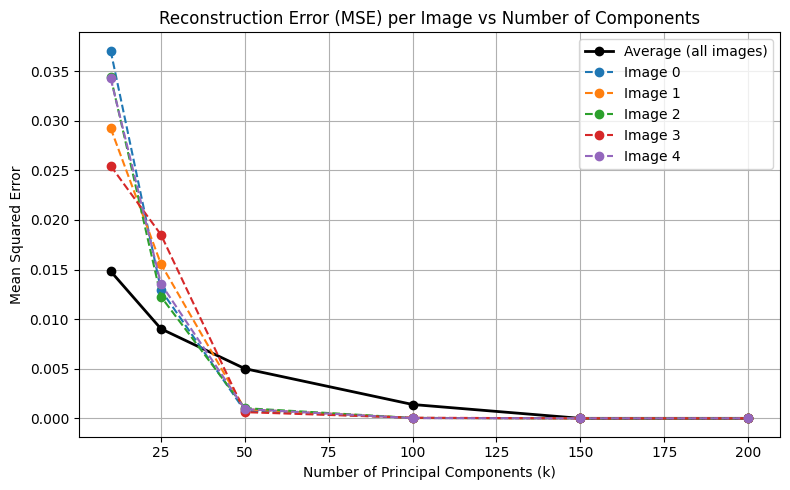

In [48]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

def analyze_pca_error_per_image(faces, k_values, sample_indices=None):
    """
    Computes and plots the reconstruction error (MSE) for each image and each PCA dimension (k),
    and shows both the dataset average and selected sample images.
    """
    # --- Data preparation ---
    X = np.array([img.flatten() for img in faces.values()], dtype=np.float64) / 255.0
    n_images = X.shape[0]

    if sample_indices is None:
        sample_indices = list(range(min(5, n_images)))  # default: first 5 images

    # Containers
    mean_mse_values = []
    explained_variances = []
    all_mse_per_k = []

    # --- Loop over k values ---
    for k in k_values:
        out = perform_pca_from_faces(faces, k=k)
        X_recon = reconstruct_from_pca(out["X_proj"], out["components"], out["mean"])

        # MSE for each image
        mse_per_image = np.mean((X - X_recon) ** 2, axis=1)
        all_mse_per_k.append(mse_per_image)

        mean_mse = np.mean(mse_per_image)
        mean_mse_values.append(mean_mse)
        explained_variances.append(out["explained_var_ratio_cum"][k-1])

        print(f"k={k:<4} | Mean MSE={mean_mse:.6f} | Explained Var={explained_variances[-1]*100:.2f}%")

    # --- Convert lists to arrays for plotting ---
    all_mse_per_k = np.array(all_mse_per_k)  # shape: (len(k_values), n_images)

    # --- Plot: average and first few images ---
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, mean_mse_values, marker='o', color='black', linewidth=2, label='Average (all images)')

    # Plot each of the selected images
    for idx in sample_indices:
        plt.plot(k_values, all_mse_per_k[:, idx], marker='o', linestyle='--', label=f'Image {idx}')

    plt.title("Reconstruction Error (MSE) per Image vs Number of Components")
    plt.xlabel("Number of Principal Components (k)")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return all_mse_per_k, mean_mse_values, explained_variances

k_values = [10, 25, 50, 100, 150, 200]
all_mse_per_k, mean_mse_values, explained = analyze_pca_error_per_image(faces, k_values)
